<a href="https://colab.research.google.com/github/isegura/seminarioUPM/blob/main/5_classifiers_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Covid-2019

In this notebook, we will explore different machine learning algorithms to classifies tweets into four sentiment classes:
<ul>
<li> Extremely Negative: 0</li>
<li> Extremely Positive: 1</li>
<li> Negative: 2</li>
<li> Neutral: 3</li>
<li> Positive: 4</li>
</ul>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
root='drive/My Drive/Colab Notebooks/seminarioUPM/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
train_data = pd.read_csv(root+'data/train.csv')
test_data = pd.read_csv(root+'data/test.csv')

# training set removing nan records
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

print("Training instances: {}, and testing instances: {}".format(train_data.shape[0],test_data.shape[0]))
print(train_data.shape)

Training instances: 41087, and testing instances: 3795
(41087, 2)


## Vectorization (transforming text to vectors)


We split the texts and their labels:

In [ ]:
# texts
text_train = train_data.iloc[:,0].copy().to_numpy()
text_test = test_data.iloc[:,0].copy().to_numpy()
# labels
y_train = train_data.iloc[:,1].copy().to_numpy().astype('int')
y_test = test_data.iloc[:,1].copy().to_numpy().astype('int')
print(text_train[0])

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


### tf-idf model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#max_df: ignore terms that have a document frequency strictly higher than the given threshold
#min_df: ignore terms that have a document frequency strictly lower than the given threshold.
#sublinear_tf: Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
#encoding='latin-1', default: utf-8
#ngram_range: lower and upper boundary of the range of n-values for different n-grams to be extracted
tfidf = TfidfVectorizer(max_features=3000, max_df=0.8, sublinear_tf=True, min_df=10, ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()
X_test = tfidf.transform(text_test).toarray()


[0. 0. 0. ... 0. 0. 0.] (3000,)


In [ ]:
print(X_train[0], X_train[0].shape)


[0. 0. 0. ... 0. 0. 0.] (3000,)


# Training


In [ ]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=0.1)
svm_model.fit(X_train, y_train)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Evaluation

In [ ]:
print("mean accuracy:",svm_model.score(X_test, y_test))

mean accuracy: 0.5322793148880105


## How to search the best hyper-parameteres

In [ ]:
from sklearn.model_selection import GridSearchCV
# applying an SVM model to it
svm = LinearSVC()
params = {'C': [0.01, 0.1, 1, 10, 100]}
grid_svm = GridSearchCV(svm, params)
grid_svm.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
grid_svm.best_params_


{'C': 1}

Now we train the model with this parameter:

In [ ]:
svm_model = LinearSVC(C=1)
svm_model.fit(X_train, y_train)
print("mean accuracy:",svm_model.score(X_test, y_test))

mean accuracy: 0.5346508563899868


##Evaluation on test dataset

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred = svm_model.predict(X_test)
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print('precision F1=',precision_score(y_test, y_pred, average='macro'))
print('recall F1=',recall_score(y_test, y_pred, average='macro'))
print('recall F1=',f1_score(y_test, y_pred, average='macro'))
print()
#Calculate metrics globally by counting the total true positives, false negatives and false positives.
print('precision F1=',precision_score(y_test, y_pred, average='micro'))
print('recall F1=',recall_score(y_test, y_pred, average='micro'))
print('recall F1=',f1_score(y_test, y_pred, average='micro'))
print()
#Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
print('weighted F1=',precision_score(y_test, y_pred, average='weighted'))
print('weighted F1=',recall_score(y_test, y_pred, average='macro'))
print('weighted F1=',f1_score(y_test, y_pred, average='macro'))

precision F1= 0.5412187684400468
recall F1= 0.5578750565463706
recall F1= 0.546658123091764

precision F1= 0.5346508563899868
recall F1= 0.5346508563899868
recall F1= 0.5346508563899868

weighted F1= 0.5313405621726981
weighted F1= 0.5578750565463706
weighted F1= 0.546658123091764


In [ ]:
from sklearn.metrics import classification_report
labels={0:'Extremely Negative',1:'Extremely Positive',2:'Negative',3:'Neutral',4:'Positive'}

scores=classification_report(y_test,y_pred,target_names=labels.values())
print(scores)

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.56      0.55       592
Extremely Positive       0.61      0.62      0.61       599
          Negative       0.50      0.40      0.44      1041
           Neutral       0.57      0.72      0.63       616
          Positive       0.49      0.50      0.50       947

          accuracy                           0.53      3795
         macro avg       0.54      0.56      0.55      3795
      weighted avg       0.53      0.53      0.53      3795



https://medium.com/swlh/confusion-matrix-and-classification-report-88105288d48f

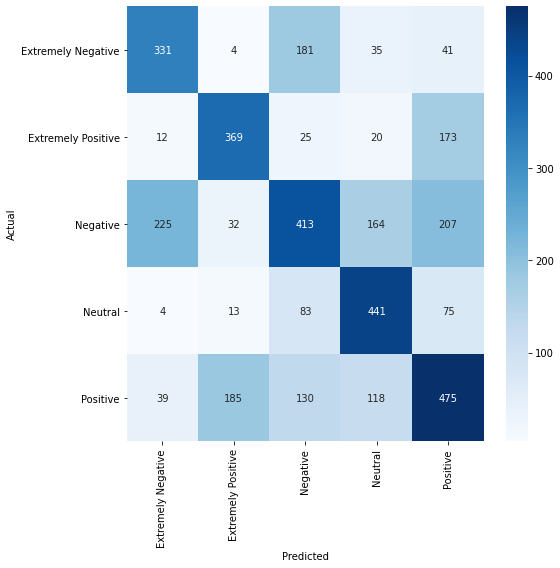

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

from matplotlib import pyplot as plt
import seaborn as sns 

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', 
            cmap='Blues',xticklabels=labels.values(), yticklabels=labels.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




# Exercise 1:
Instead of using tf-idf, you can use the vectors provided by Spacy to represent the texts. 
Then, you can train a classifier on these vectors.

In [ ]:
#!python -m spacy download en_core_web_lg
import spacy
nlp = spacy.load("en_core_web_lg")

Represent texts using the  vectors provided by spacy

In [ ]:
X_train=[]
X_test=[]

for text in text_train:
    doc = nlp(text)
    X_train.append(doc.vector)

for text in text_test:
    doc = nlp(text)
    X_test.append(doc.vector)


In [ ]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(C=0.1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

scores=classification_report(y_test,y_pred,target_names=labels.values())
print(scores)

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.42      0.47       592
Extremely Positive       0.60      0.45      0.52       599
          Negative       0.46      0.45      0.45      1041
           Neutral       0.45      0.60      0.51       616
          Positive       0.42      0.46      0.44       947

          accuracy                           0.47      3795
         macro avg       0.49      0.48      0.48      3795
      weighted avg       0.48      0.47      0.47      3795



## Exercise 2:

Train a logistic regression classifier on the training dataset. You should try with different values for the parameter 'C':  [1, 10, 25, 30].

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Once you have found the best setting for the classifier, train the model and evaluate it on the test dataset.


In [ ]:
from sklearn.linear_model import LogisticRegression

# simple lr with saga solver takes waay more time and gives the same result
lr = LogisticRegression(max_iter=1000,C=1) #solver='saga')
lr.fit(X_train, y_train)
print("mean accuracy:",lr.score(X_test, y_test))

mean accuracy: 0.5525691699604743


In [ ]:
scores=classification_report(y_test,y_pred,target_names=labels.values())
print(scores)

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.56      0.55       592
Extremely Positive       0.61      0.62      0.61       599
          Negative       0.50      0.40      0.44      1041
           Neutral       0.57      0.72      0.63       616
          Positive       0.49      0.50      0.50       947

          accuracy                           0.53      3795
         macro avg       0.54      0.56      0.55      3795
      weighted avg       0.53      0.53      0.53      3795

